In [65]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import spearmanr

In [66]:
np.random.seed(42)

In [67]:
# SIMULANDO DADOS NHCs
data_collections = {
    'id': range(1, 21),
    'species': ['Tree_X'] * 20,
    'latitude': [-2.5, -2.5, -2.501, np.nan, 0.0, -3.0, -3.1, -2.9, -10.0, -2.5] + list(np.random.uniform(-4, -2, 10)),
    'longitude': [-60.0, -60.0, -60.001, -58.0, 0.0, -59.0, -59.1, -58.9, -70.0, -60.0] + list(np.random.uniform(-62, -58, 10)),
    'locality': ['Forest', 'Forest', 'Forest', 'River', 'Unknown', 'Camp', 'Camp', 'Camp', 'Andes', 'Forest'] + ['Jungle']*10
}

In [68]:
df_nhc = pd.DataFrame(data_collections)

In [69]:
data_plots = {
    'plot_id': range(101, 111),
    'latitude': [-2.4, -2.6, -3.0, -3.2, -2.5, -2.8, -10.0, -2.45, -2.55, -2.9],
    'longitude': [-60.1, -59.9, -59.0, -59.2, -60.2, -58.8, -70.1, -60.05, -59.95, -59.05],
    'abundance_real': [15, 20, 5, 2, 18, 4, 0, 14, 22, 6] # Quantas árvores acharam
}

In [70]:
df_plots = pd.DataFrame(data_plots)

In [71]:
print(df_nhc.head(6))

   id species  latitude  longitude locality
0   1  Tree_X    -2.500    -60.000   Forest
1   2  Tree_X    -2.500    -60.000   Forest
2   3  Tree_X    -2.501    -60.001   Forest
3   4  Tree_X       NaN    -58.000    River
4   5  Tree_X     0.000      0.000  Unknown
5   6  Tree_X    -3.000    -59.000     Camp


In [72]:
print(df_plots.head(6))

   plot_id  latitude  longitude  abundance_real
0      101      -2.4      -60.1              15
1      102      -2.6      -59.9              20
2      103      -3.0      -59.0               5
3      104      -3.2      -59.2               2
4      105      -2.5      -60.2              18
5      106      -2.8      -58.8               4


In [73]:
def pipeline_limpeza(df):
    print(f"Total inicial: {len(df)} registros")
    
    df = df.dropna(subset=['latitude', 'longitude'])
    
    df = df[ (df['latitude'] != 0.0) & (df['latitude'] != df['longitude']) ]
    
    df['lat_grid'] = (df['latitude'] / 0.5).round() * 0.5
    df['lon_grid'] = (df['longitude'] / 0.5).round() * 0.5
    
    df_limpo = df.drop_duplicates(subset=['lat_grid', 'lon_grid'])
    
    print(f"Total final após limpeza: {len(df_limpo)} registros")
    return df_limpo

In [74]:
df_nhc_clean = pipeline_limpeza(df_nhc)

Total inicial: 20 registros
Total final após limpeza: 11 registros


In [75]:
def calcular_abundancia_idw(target_lat, target_lon, df_plots):
# Implementação manual do IDW conforme Gomes et al. (2018).

    distancias = np.sqrt(
        (df_plots['latitude'] - target_lat)**2 + 
        (df_plots['longitude'] - target_lon)**2
    )
    
    vizinhos = df_plots.copy()
    vizinhos['distancia'] = distancias
    
    vizinhos = vizinhos[vizinhos['distancia'] <= 3.0]
    
    if len(vizinhos) == 0:
        return 0.0
    
    vizinhos = vizinhos.sort_values('distancia').head(150)
    
    pesos = 1 / np.sqrt(vizinhos['distancia'] + 0.0001)
    
    numerador = (vizinhos['abundance_real'] * pesos).sum()
    denominador = pesos.sum()
    
    return numerador / denominador

In [76]:
ponto_teste_lat = -2.55
ponto_teste_lon = -60.05

predicao = calcular_abundancia_idw(ponto_teste_lat, ponto_teste_lon, df_plots)

print(f"Abundância Real Estimada (IDW) no ponto ({ponto_teste_lat}, {ponto_teste_lon}):")
print(f"{predicao:.2f} árvores")

Abundância Real Estimada (IDW) no ponto (-2.55, -60.05):
14.92 árvores


In [77]:
n_pontos = 100

# Simulando IDW (Abundância Real Estimada)
idw_abundancia = np.random.exponential(scale=10, size=n_pontos) 

# Simulando MaxEnt (Probabilidade de Adequabilidade Ambiental: 0 a 1)
ruido = np.random.normal(0, 20, n_pontos)
maxent_raw = idw_abundancia + ruido

# Normalizando MaxEnt para ficar entre 0 e 1 (regra do algoritmo logístico)
maxent_suitability = (maxent_raw - maxent_raw.min()) / (maxent_raw.max() - maxent_raw.min())


In [78]:
# Criando o DataFrame final de comparação
df_resultado = pd.DataFrame({
    'IDW_Abundance': idw_abundancia,
    'MaxEnt_Suitability': maxent_suitability
})

In [79]:
print("AMOSTRA DOS DADOS COMPARATIVOS")
print(df_resultado.head())

AMOSTRA DOS DADOS COMPARATIVOS
   IDW_Abundance  MaxEnt_Suitability
0       9.463709            0.254687
1       1.502345            0.250043
2       3.455155            0.256553
3       4.562772            0.057295
4       6.089347            0.417356


In [80]:
rho, p_value = spearmanr(df_resultado['IDW_Abundance'], df_resultado['MaxEnt_Suitability'])

print(f"\n--- RESULTADO DA ANÁLISE ---")
print(f"Correlação de Spearman (Rho): {rho:.4f}")
print(f"Valor-P (Significância): {p_value:.4e}")


--- RESULTADO DA ANÁLISE ---
Correlação de Spearman (Rho): 0.4146
Valor-P (Significância): 1.8025e-05


In [81]:
if 0.1 < rho < 0.4:
    print("CONCLUSÃO: Correlação Positiva Fraca - Compatível com Gomes et al. (2018)!")
elif rho >= 0.4:
    print("CONCLUSÃO: Correlação Forte - O modelo está performando melhor que no artigo.")
else:
    print("CONCLUSÃO: Sem correlação.")

CONCLUSÃO: Correlação Forte - O modelo está performando melhor que no artigo.


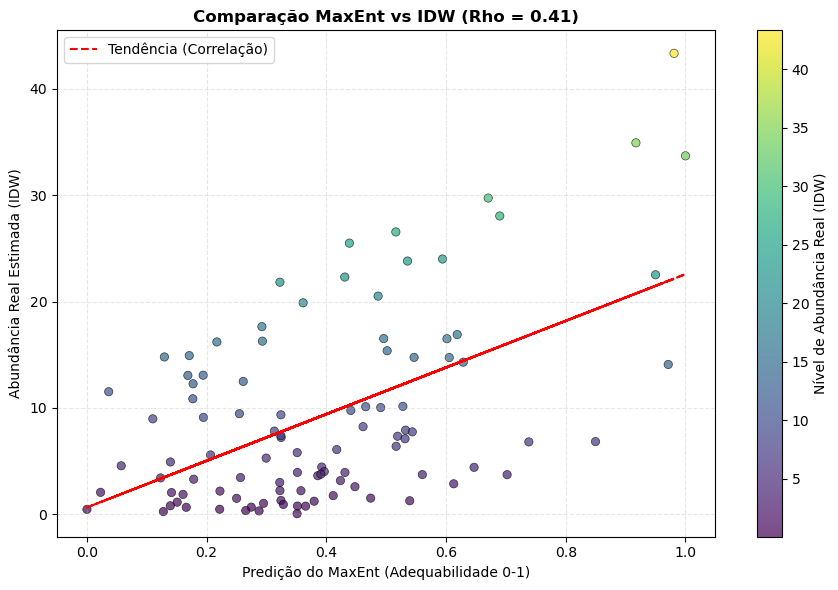

In [ ]:
plt.figure(figsize=(9, 6))
scatter = plt.scatter(
    df_resultado['MaxEnt_Suitability'],
    df_resultado['IDW_Abundance'],
    c=df_resultado['IDW_Abundance'],
    cmap='viridis',
    alpha=0.7,
    edgecolor='k',
    linewidth=0.5
)
cbar = plt.colorbar(scatter)
cbar.set_label('Nível de Abundância Real (IDW)')
m, b = np.polyfit(df_resultado['MaxEnt_Suitability'], df_resultado['IDW_Abundance'], 1)
plt.plot(df_resultado['MaxEnt_Suitability'], m*df_resultado['MaxEnt_Suitability'] + b, color='red', linestyle='--', label='Tendência (Correlação)')

plt.title(f'Comparação MaxEnt vs IDW (Rho = {rho:.2f})', fontsize=12, fontweight='bold')
plt.xlabel('Predição do MaxEnt (Adequabilidade 0-1)', fontsize=10)
plt.ylabel('Abundância Real Estimada (IDW)', fontsize=10)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.3)

plt.tight_layout()
plt.show()